In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import os
import glob
import cv2
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as tarnsforms
from torch.utils.data import Dataset, DataLoader

#전처리

In [ ]:
#데이터 전처리
import torchvision.transforms as transforms
train_path = '/content/drive/MyDrive/ColabNotebooks/Face_Mask_Dataset/Train'
test_path = '/content/drive/MyDrive/ColabNotebooks/Face_Mask_Dataset/Validation'
tf = transforms.Compose([transforms.Resize((224,224)),  
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,),(0.5,))
])
# transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

train_data = datasets.ImageFolder(root = train_path,transform=tf) #이미지폴더로 불러오고

test_data = datasets.ImageFolder(root = test_path,transform=tf)


In [ ]:
len(train_data)

10000

In [ ]:
classes = train_data.classes
classes

['WithMask', 'WithoutMask']

In [ ]:
batch_size=32
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last = True)  #데이터로더로 확인 
testloader = DataLoader(test_data, batch_size=batch_size)
train_images, train_labels = iter(trainloader).next()
print(train_labels)
type(train_labels)

tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0])


torch.Tensor

In [ ]:
train_images.shape, train_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#ResNet50

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

resnet50 = models.resnet50(pretrained = True)

for param in resnet50.parameters():   #가중치 freeze
  param.requires_grad = False

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_classes = 1
num_ftrs = resnet50.fc.in_features  #resnet50의 채널 수

resnet50.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)

criterion = nn.BCEWithLogitsLoss()  #Sigmoid 레이어와 BCELoss를 하나로 합친 것(따로쓰는것보다 수치 안정성을 가진다)

optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size =7, gamma=0.1)


In [ ]:

from tqdm import tqdm

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    pbar = tqdm(enumerate(dataloader), total = len(dataloader)) #
    learning_loss = 0
    sum_loss = 0

    for batch, (X, y) in pbar:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        # print("\n========================================================")
        # print(torch.squeeze(pred))
        # print("--------------------------------------------------------")
        # print((torch.squeeze(pred) > 0).type(torch.float))
        # print("--------------------------------------------------------")
        # print(y)
        # print("========================================================")

        loss = loss_fn(pred, torch.unsqueeze(y, dim = 1).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss = sum_loss + loss.item() #
        learning_loss = sum_loss / (batch + 1)
        description = f'running loss : {round(learning_loss, 4)}'
        pbar.set_description(description)

def test(dataloader, model, loss_fn):
    model.eval()  #
    pbar = tqdm(enumerate(dataloader), total = len(dataloader)) #
    learning_loss = 0
    sum_loss = 0
    learning_acc = 0
    sum_acc = 0
    correct = 0

    for batch, (X, y) in pbar:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      loss = loss_fn(pred,torch.unsqueeze(y, dim = 1).float())  ##

      correct = ((torch.squeeze(pred) > 0)==y).type(torch.float).sum().item()
      acc = correct / batch_size
      sum_acc += acc
      learning_acc = sum_acc / (batch + 1)
      sum_loss = sum_loss + loss.item() #
      learning_loss = sum_loss / (batch + 1)
      description = f'running loss : {learning_loss}  || running acc : {learning_acc}'
      pbar.set_description(description)

    return learning_acc

In [ ]:
a = round(0.4)
print(a)

0


In [ ]:
epochs = 20
best_acc = 0


for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader,resnet50,criterion,optimizer_ft)
  acc = test(testloader,resnet50,criterion)
  if acc > best_acc:
    best_acc = acc
    torch.save(resnet50.state_dict(),f'/content/drive/MyDrive/ColabNotebooks/maskmodel_{acc}.pt') #(모델의 현재 파라미터저장,저장경로)
    

Epoch 1
-------------------------------


running loss : 0.1484: 100%|██████████| 312/312 [01:14<00:00,  4.19it/s]
running loss : 0.06424508627504111  || running acc : 0.97875: 100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


Epoch 2
-------------------------------


running loss : 0.073: 100%|██████████| 312/312 [01:08<00:00,  4.57it/s]
running loss : 0.03814014669507742  || running acc : 0.99375: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]


Epoch 3
-------------------------------


running loss : 0.055: 100%|██████████| 312/312 [01:07<00:00,  4.59it/s]
running loss : 0.036661794148385524  || running acc : 0.99125: 100%|██████████| 25/25 [00:05<00:00,  4.72it/s]


Epoch 4
-------------------------------


running loss : 0.0458: 100%|██████████| 312/312 [01:05<00:00,  4.74it/s]
running loss : 0.026021256344392896  || running acc : 0.99625: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s]


Epoch 5
-------------------------------


running loss : 0.0445: 100%|██████████| 312/312 [01:06<00:00,  4.69it/s]
running loss : 0.024643585123121738  || running acc : 0.99625: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Epoch 6
-------------------------------


running loss : 0.0406: 100%|██████████| 312/312 [01:06<00:00,  4.67it/s]
running loss : 0.0200265248445794  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s]


Epoch 7
-------------------------------


running loss : 0.0415: 100%|██████████| 312/312 [01:06<00:00,  4.66it/s]
running loss : 0.018193703482393176  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s]


Epoch 8
-------------------------------


running loss : 0.0352: 100%|██████████| 312/312 [01:07<00:00,  4.64it/s]
running loss : 0.016393570052459835  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.92it/s]


Epoch 9
-------------------------------


running loss : 0.0381: 100%|██████████| 312/312 [01:06<00:00,  4.70it/s]
running loss : 0.015314687388017773  || running acc : 0.9975: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


Epoch 10
-------------------------------


running loss : 0.0325: 100%|██████████| 312/312 [01:07<00:00,  4.62it/s]
running loss : 0.014418438323773444  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


Epoch 11
-------------------------------


running loss : 0.0314: 100%|██████████| 312/312 [01:07<00:00,  4.60it/s]
running loss : 0.014235464399680495  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


Epoch 12
-------------------------------


running loss : 0.0278: 100%|██████████| 312/312 [01:07<00:00,  4.62it/s]
running loss : 0.012916317095514386  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


Epoch 13
-------------------------------


running loss : 0.0296: 100%|██████████| 312/312 [01:07<00:00,  4.63it/s]
running loss : 0.013424925443250685  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.65it/s]


Epoch 14
-------------------------------


running loss : 0.031: 100%|██████████| 312/312 [01:07<00:00,  4.63it/s]
running loss : 0.013065417737234384  || running acc : 0.9975: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Epoch 15
-------------------------------


running loss : 0.0316: 100%|██████████| 312/312 [01:08<00:00,  4.58it/s]
running loss : 0.01085990916704759  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Epoch 16
-------------------------------


running loss : 0.0318: 100%|██████████| 312/312 [01:08<00:00,  4.55it/s]
running loss : 0.011120309405960142  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


Epoch 17
-------------------------------


running loss : 0.0232: 100%|██████████| 312/312 [01:07<00:00,  4.60it/s]
running loss : 0.013548539483454079  || running acc : 0.9975: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]


Epoch 18
-------------------------------


running loss : 0.0289: 100%|██████████| 312/312 [01:07<00:00,  4.60it/s]
running loss : 0.0109382335934788  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s]


Epoch 19
-------------------------------


running loss : 0.0243: 100%|██████████| 312/312 [01:06<00:00,  4.69it/s]
running loss : 0.01125559640582651  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]


Epoch 20
-------------------------------


running loss : 0.0258: 100%|██████████| 312/312 [01:07<00:00,  4.64it/s]
running loss : 0.009786971363937483  || running acc : 0.99875: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


#mask / no mask 테스트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install cvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.1 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046385 sha256=9b8f172d99f120f7cbeafae12af1d441cf100b48bdd0e626ec147570fb1618d3
  Stored in directory: /root/.cache/pip/wheels/8e/d7/31/bc643bd3a8b11a7368b1ab1d8a6299b33b462ed0b0683ddc5a
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=58a076540c5cb6d72d108f3be8840186264acb79aec87f81da8e2e9917442670
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

path = '/content/drive/MyDrive/ColabNotebooks/maskmodel_0.99875.pt'

resnet50 = models.resnet50(pretrained = True)
for param in resnet50.parameters():   #가중치 freeze
  param.requires_grad = False

num_classes = 1
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)


resnet50.load_state_dict(torch.load(path))
resnet50.eval()  #Dropout, Batchnorm 등의 기능 비활성화


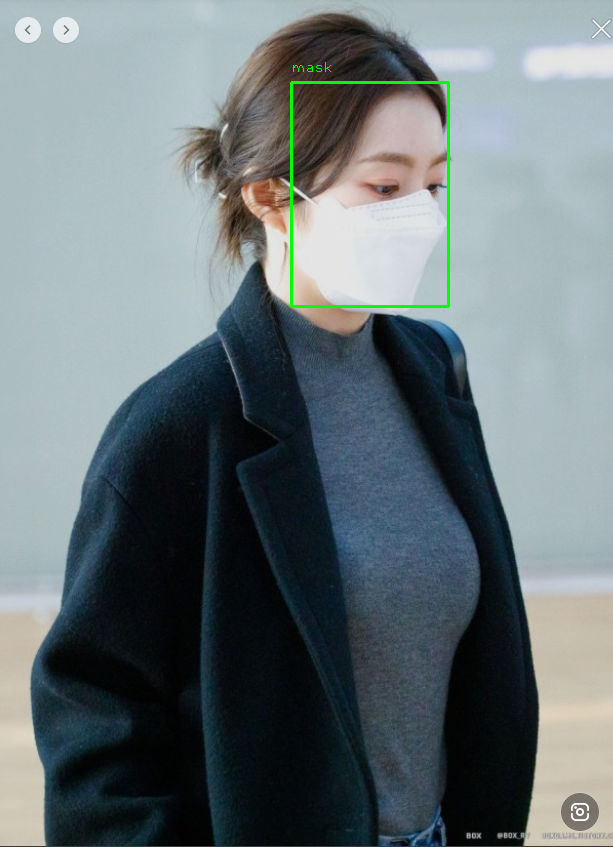

In [ ]:
import cv2
import cvlib as cv
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

img = cv2.imread('example5.PNG')  #png파일로 넣어야 함
faces, confidences = cv.detect_face(img)  #faces : detect한 얼굴 위치 좌표  #confidences: 얼굴일 확률

tf = transforms.Compose([transforms.Resize((224,224)),  
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,),(0.5,))
])

for (x,y,x2,y2), conf in zip(faces, confidences):
  face = img[y:y2,x:x2]
  face = Image.fromarray(face)
  face = tf(face).unsqueeze(0)  #resnet50에 넣기 위해 4D로 변환 후 모델에 넣기위해 transform
  face = face.to(device)  
  pred = resnet50(face) #마스크 예측

  if torch.squeeze(pred) > 0 :
    cv2.putText(img,'no mask',(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(0,0,255),1)
    cv2.rectangle(img, (x,y), (x2,y2), (0,0,255), 2)
  else:
    cv2.putText(img,'mask' ,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(0,255,0),1)
    cv2.rectangle(img, (x,y), (x2,y2), (0,255,0), 2)

cv2_imshow(img)
key = cv2.waitKey(0)
cv2.destroyAllWindows()